**Student Name**: Mohamed Darkaoui

**Student ID**: s0185350

# Policy Gradient Playground session

In this lab, we'll simply explore how to come up with the Policy Gradient formulas, and hopefully give a bit more insight. We will go through the lab together and implement the **TODOs**. To get full marks on this lab, you only need to fill the TODOs with what we fill during the session, and run the cells. If you can't access the session, please try to fill in the **TODOs** by yourself, and ask for confirmation on your answers by mail. Please only use this road if there is a specific reason you can't attend the lab.

The lab, and in particular the visuals, is heavily taken from [this blog post](https://towardsdatascience.com/an-intuitive-explanation-of-policy-gradient-part-1-reinforce-aa4392cbfd3c). We found his code a bit confusing, so we implemented something hopefully a bit easier to follow. 

## Policy Gradient Reminder
We parametrize our policy $\pi$ with a vector of parameters $\boldsymbol{\theta} \in \mathbb{R}^d$. We want to maximize the obtained reward; in other words, we want to find the set of parameters $\boldsymbol{\theta}$ for which our policy $\pi_\boldsymbol{\theta}$ becomes optimal. How should we select $\boldsymbol{\theta}$? Well, we know that the [gradient of a function is the direction of *steepest ascent*](https://www.khanacademy.org/math/multivariable-calculus/multivariable-derivatives/gradient-and-directional-derivatives/v/why-the-gradient-is-the-direction-of-steepest-ascent): if we keep following the gradient, the function's value will be maximal locally. Here the function we want to maximize is the expected return from an initial state, $\mathbb{E}_{\pi_\boldsymbol{\theta}, p}[G_0]$. We want to find $\boldsymbol{\theta}$ to maximize this, so therefore formally the problem is 
$$ \max J\left( \boldsymbol{\theta} \right) = \mathbb{E}_{\pi_\boldsymbol{\theta}, p}[G_0] $$

To maximize this, we know we can move $\boldsymbol{\theta}$ in the gradient of $J$ w.r.t $\boldsymbol{\theta}$, $\nabla_\boldsymbol{\theta} J$. However the final formula for it can be very unfriendly,  with a wild $\hat{A}(s, a) \nabla_\boldsymbol{\theta} \log \pi_\boldsymbol{\theta}\left(a \mid s\right)$ term popping up. 

Even with the math laid out in front of you, this update might not make sense. Why would I move my $\boldsymbol{\theta}$ in the direction of this thing? Why, intuitively, did $\hat{A}$ and $\nabla_\boldsymbol{\theta} \log \pi$ appear in there?

Let's make this formula intuitive!

## 1. Starters

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, Image

### 1.1. <span style="color:blue"> **TODO** </span> Parametrized Policy
First, we need a policy $\pi_\boldsymbol{\theta}$. Like in the Gradient Bandit, and all the way to Neural Nets, we will use a softmax policy: starting from a parameter vector $\boldsymbol{\theta} \in \mathbb{R}^d$, the softmax simply turns these values into probabilities using
$$ \sigma(\boldsymbol{\theta})_i = \frac{e^{\theta_i}}{\sum_{j=1}^K e^{\theta_j}} = \pi_\boldsymbol{\theta}\left( a_i \mid s \right)$$
How about the gradient of our softmax $\sigma$? What we are interested in is the gradient for a specific action $a_j$: **the steepest ascent $\boldsymbol{\theta}$ to raise the probability of action $a_j$**. You can compute it, or trust us that it conveniently turns out to be defined with softmaxes:
$$ \frac{ \partial \sigma(\boldsymbol{\theta})_i} {\partial \theta_j} = \sigma(\boldsymbol{\theta})_j \left( \delta_{ij} - \sigma(\boldsymbol{\theta})_i  \right) \ \ \ \ \text{or with } \pi: 
\frac{ \partial \pi_\boldsymbol{\theta}\left(a_i \mid s \right)} {\partial \theta_j} = \pi_\boldsymbol{\theta}\left(a_j \mid s \right) \left( \delta_{ij} - \pi_\boldsymbol{\theta}\left(a_i \mid s \right)  \right)$$

(on a sidenote, the gradient of the softmax is actually symmetrial in $i,j$.)

For a Neural Net, the softmax takes the previous layer as input instead of the whole $\boldsymbol{\theta}$ and therefore looks like an activation function. It's not that! It's only to force the output to be a distribution; an ANN doesn't need an activation on the output.

Let's define our terms!

In [3]:
# Parameters of your policy:
theta = np.array([0.,0.,0.]) # sometimes called logits of the softmax

In [4]:
def pi(theta): # Softmax function
    """ Compute softmax values for each sets of scores in x:preferences.
    Substracting the max doesn't change the output but is more numerically stable"""
    e_theta = np.exp(theta - np.max(theta))
    return e_theta / e_theta.sum()

def grad_pi(theta, action):
    """ Gradient at a given action """
    delta_ai = np.zeros(3)
    delta_ai[action] = 1. # =1 where i=a, 0 elsewhere
    pi_theta = pi(theta)
    return pi_theta[action]*(delta_ai-pi_theta)

### 1.2. Environment?
This is a RL problem, we need an environment! But to make this as easy as possible, we'll only consider a one-state environment (Bandit problem!), and pretend that there is more happening downstream. In other words, we're going to pretend we're observing a full return $G_t$ for having taken our action in this state. From our state $s$, we have 3 possible actions, leading to different noisy returns. We choose randomly that action $1$ has average return $1$; action $2$ has average return $0.5$ and action $3$ has average return $0.25$. We know that the whole RL process with stochastic actions and transitions is very noisy, so let's assume a noise of std $0.2$ for all returns.

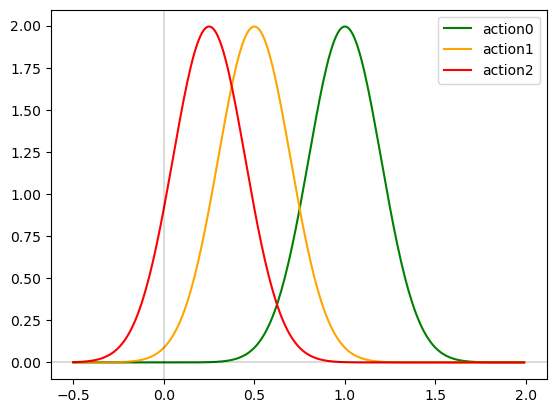

In [5]:
def return_function(action):
    """ Complete Return obtained after performing this action """
    noise = .2
    if action == 0:
        return 1 + np.random.randn()*noise
    elif action == 1:
        return .5 + np.random.randn()*noise
    elif action == 2:
        return .25 + np.random.randn()*noise
    else:
        raise ValueError("Invalid action {}".format(action))
        
def gaussian(x, mu, sigma=0.2):
      return 1./(sigma*np.sqrt(2*np.pi))*np.exp(-1/2* ((x - mu)/sigma)**2.)

        
x = np.arange(-.5,2, 0.01)
plt.plot(x, gaussian(x, 1.), color='green', label="action0")
plt.plot(x, gaussian(x, .5), color='orange', label="action1")
plt.plot(x, gaussian(x, .25), color='red', label="action2")
plt.axhline(0, color="black", linewidth=0.2)
plt.axvline(0, color="black", linewidth=0.2)
plt.legend()
plt.show()

Note that since this is a Bandit setting, we are eventually going to implement Gradient Bandit, but it's important to see that we can imagine a whole MDP sprouting from our state.

### 1.3. <span style="color:blue"> **TODO** </span> Learning Loop

Now let's implement the good old RL learning loop. Instead of doing a fixed amount of steps, we'll stop when the algo believes an action is much more interesting than the others: when its probability is higher than $0.9$.

In [6]:
def learn(theta, return_fn, update_fn, act=None):
    """ RL learning loop. 
    Returns visualization variables. """
    threshold = 0.9
    thetas = [theta]
    pis = [pi(theta)]
    incs, incs_idx = [0], [0]
    while not np.any(pi(theta) > threshold): # call this convergence
        # RL: act, observe, learn
        a = act(theta) if act is not None else np.random.randint(3)
        gt = return_fn(a)
        theta, inc, inc_idx = update_fn(theta, a, gt)
        
        # visualization stuff
        thetas.append(theta)
        pis.append(pi(theta))
        incs.append(inc)
        incs_idx.append(inc_idx)

    return thetas, pis, incs, incs_idx

### 1.4. Visualization
This is the method used to generate the animation; you can ignore this.

In [7]:
def plot_animation(i, thetas, pis, incs, incs_idx, fig, ax1, ax2):
    theta, pi, inc, inc_idx = thetas[i], pis[i], incs[i], incs_idx[i]
    labels = ['Ret = 1', 'Ret = .5', 'Ret = .25']
    # Axis 1: Action Probabilities
    ax1.clear()
    ax1.bar(labels, pi, width=0.5)
    ax1.set_ylim(0, 1.19)
    ax1.set_title("Policy")

    # Axis 2: Theta (Softmax Logits) 
    ax2.clear()
    ax2.bar(labels, theta, width=0.5)
    ax2.set_ylim(-1.25, 2.5)
    ax2.axhline(0, linewidth=0.5)
    ax2.set_title("Theta (Softmax Logits)")
    positive = (inc >= 0)
    color = 'green' if positive else 'red'
    ax2.annotate('',
        xy=(inc_idx, theta[inc_idx]+positive*inc), xycoords='data',
        xytext=(inc_idx, theta[inc_idx] - (1-positive)*inc), textcoords='data',
        arrowprops=dict(width=2, connectionstyle="arc3", color=color, headlength=6, headwidth=8)
    )
    return fig,

def animate(filename, thetas, pis, incs, incs_idx):
    print("Animating {} frames...".format(len(thetas)))
    init = time.time()
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    ani = animation.FuncAnimation(fig, plot_animation, frames=list(range(0, len(thetas))), 
                                  fargs=(thetas, pis, incs, incs_idx, fig, ax1, ax2), blit=False)
    ani.save(filename, writer='ffmpeg', fps=10) # 'pillow', 'imagemagick'
    print("Done animating in {}s".format(time.time()-init))
    plt.close()
    display(Image(filename))

### 2.5. Utils
Useful stuff we'll need on the way; you can ignore this as well.

In [10]:
def my_random_choice(v, p=None):
    """ Faster version of the np.random.choice function with probabilities """
    if p is None:
        return v[np.random.randint(len(v))]
    # else (general case)
    assert (abs(sum(p)-1.)<1e-6), "Invalid probability vector p, sum={}".format(sum(p))
    r = np.random.rand()
    i = 0
    s = p[i]
    while s < r:
        i += 1
        s += p[i]

    if type(v) is int:
        assert len(p) == v, "Int doesn't match proba length: {} != {}".format(v, len(p))
        return i
    else:
        assert len(v) == len(p), "Incorrect entry lengths v,p: {} != {}".format(len(v), len(p))
        return v[i]

## 2. Building our way Up

### 2.0 Gradient Ascent
Let us start with a reminder on Gradient Ascent. Let say we want to maximize a function $f(x)=-2x^2 +3x +4$ of which we know the gradient $\nabla_x f(x)$:

In [11]:
def f(x):
    return -2*x**2 + 3*x + 4

def grad_f(x):
    return -4*x+3

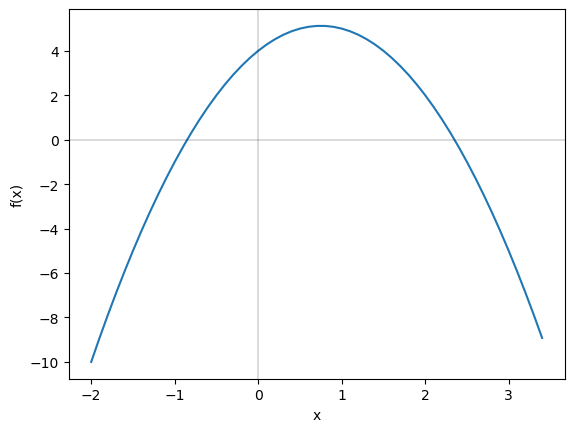

In [12]:
x = np.arange(-2,3.5, 0.1)
plt.plot(x, f(x))
plt.axhline(0, color="black", linewidth=0.2)
plt.axvline(0, color="black", linewidth=0.2)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

We can apply Gradient Ascent by starting from a random point $x_0=-2$ and repeating 
$$ x_{k+1} = x_k + \alpha \nabla_{x} f(x_k) $$

In [13]:
lr = 0.1
xk = -2 # x0
xs = [xk]
for i in range(10):
    xk = xk + lr*grad_f(xk)
    xs.append(xk)
xs = np.array(xs)

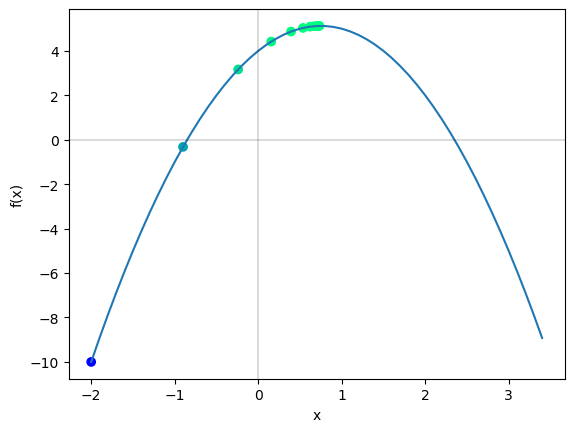

In [14]:
x = np.arange(-2,3.5, 0.1)
plt.plot(x, f(x))
plt.axhline(0, color="black", linewidth=0.2)
plt.axvline(0, color="black", linewidth=0.2)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.scatter(xs, f(xs), c=f(xs), cmap='winter')
plt.show()

This was for a single-variable function. For a parametric function (special cases of multivariable functions), you can increase the value of certain outputs for certain inputs, by tweaking your parameters.

Because of the nature of the softmax and distributions in general, raising the probability of one action will mean decreasing the probability of others. If we want to raise the probability of a given action, we simply need to follow the gradient: 
    $$\boldsymbol{\theta} = \boldsymbol{\theta} + \alpha \nabla_\theta \pi_\boldsymbol{\theta}\left(a \mid s\right)$$
This update will make action $a$ more probable and the others actions less probable.

### 2.1. <span style="color:blue"> **TODO** </span> Perfect-knowledge Agent
First, imagine that we have perfect knowledge of the best action $a^*=0$. How can we tell our agent to use this action over others? Well, we want to raise the probability to take that action, $\pi_\boldsymbol{\theta}\left(a^* \mid s\right)$. We know that the gradient indicates the direction of steepest ascent, so to raise a function's value, we can simply move $\boldsymbol{\theta}$ in direction of the gradient:
$$\boldsymbol{\theta} = \boldsymbol{\theta} + \alpha \nabla_\theta \pi_\boldsymbol{\theta}\left(a^* \mid s\right)$$

So this is an easy win:

In [15]:
lr = 0.25

def perfect_learner(theta, a, G_t):
    """ Ignores everything to just update the probability of the best action
    We want this function to also return the direction term and the used action, 
    so we can visualize things"""
    grad_term = grad_pi(theta,0) # TODO; best action = 0
    return theta + lr*grad_term, grad_term[0], 0

In [16]:
theta_0 = np.array([0.,0.,0.])
thetas, pis, incs, incs_idx = learn(theta_0, return_function, perfect_learner)

Let's see how it did!

MovieWriter ffmpeg unavailable; using Pillow instead.


Animating 44 frames...
Done animating in 7.372223138809204s


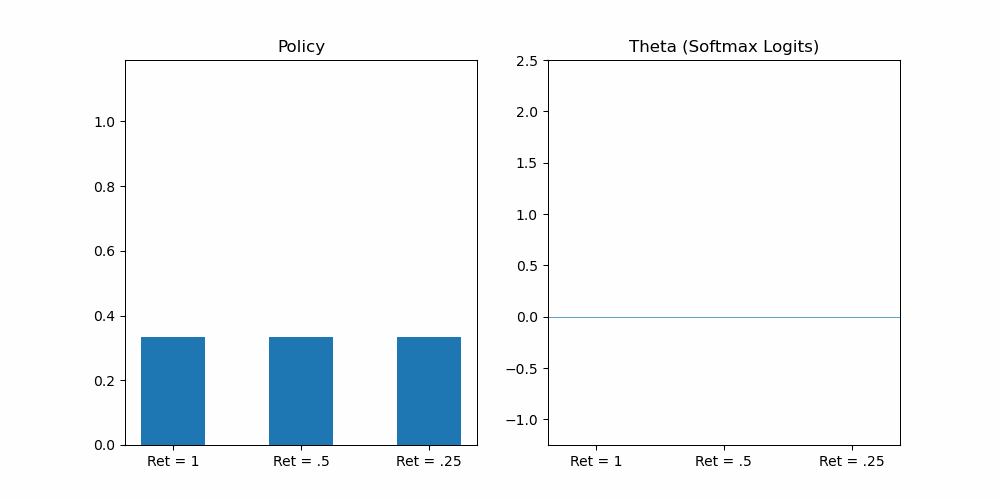

In [17]:
animate('perfect_learner.gif', thetas, pis, incs, incs_idx)

Awesome! The algorithm smoothly raises the probability to select the action by raising its preference -- from a higher-level perspective, it finds values of $\theta$ to make $a^*$ more probable..

We can see that due to the gradient of the softmax, actions that were not selected also see their preferences change: if the selected action is considered good (positive gradient), the other actions see their preference and probabilities decrease; otherwise they increase.

### 2.2. <span style="color:blue"> **TODO** </span>  Return-guided agent
Now we need to obtain similar results while the agent is *not* aware of the best action. 

What we *eventually* want to reach is that **the gradient is positive for the best actions, and negative for suboptimal actions**. If this is the case, then the probability of good actions will rise, and bad actions will decline.

The learning signal is the return $G_t$ obtained by using this action. Therefore a simple way to motivate good actions is simply to multiply the gradient by the return: if the return is often a big positive, the action will prevail over small positives and negatives. This is the simplest implementation of Policy Gradient methods. The update rule is therefore:
$$\boldsymbol{\theta} = \boldsymbol{\theta} + \alpha G_t \nabla \pi_\boldsymbol{\theta}\left(a \mid s\right)$$

**We're still acting randomly**, so it's now quite PG yet. We use the obtained returns $G_t$ from using action $a$ to guide and amplify our gradient. Let's try it!

In [18]:
lr = 0.25

def return_guided(theta, a, G_t):
    """ Uses G_t as information to drive its gradient. """
    grad_term = G_t * grad_pi(theta, a) # TODO return-guided gradient
    return theta + lr*grad_term, grad_term[a], a

Let's test it! As this is now involving a lot of stochasticity, you can run the code multiple times to get a feel of how it's doing.

MovieWriter ffmpeg unavailable; using Pillow instead.


Animating 263 frames...
Done animating in 47.16518688201904s


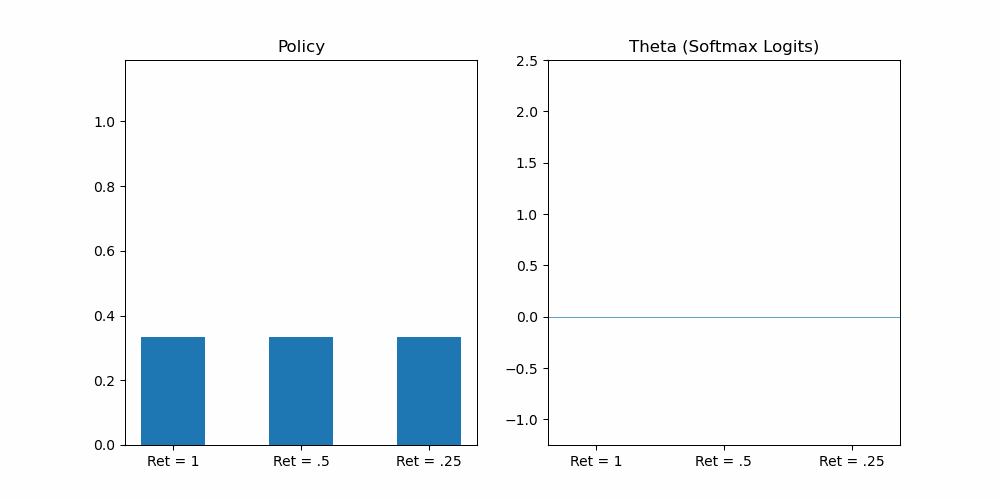

In [19]:
theta_0 = np.array([0.,0.,0.])
thetas, pis, incs, incs_idx = learn(theta_0, return_function, return_guided, act=None)
animate('return_guided.gif', thetas, pis, incs, incs_idx)

Note how stochastic it is! Using the full return comes with a very high variance. Since our returns are mostly positive, the gradient tends to augment all probabilities; the best action ends up winning simply because its updates have greater magnitude due to higher average $G_t$.

This dependence on the magnitudes of $G_t$ is important because $G_t$ has no obligation to be well-behaved!

### 2.3. <span style="color:blue"> **TODO** </span> On-policy Correction
This agent is still taking random actions. Obviously, what we eventually want is to select the actions according to our policy $\pi$. This is called **on-policy learning**. We saw several advantages to it in the course; the main notable one is that we want to use actions that lead us to interesting parts of the environment, to learn what we need most to know. In some practical cases, we also appreciate having good performance along the way.

How about we try it?

In [20]:
def act(theta):
    """ Samples from the softmax policy pi_theta=sigma(theta) """
    a = my_random_choice(len(theta), pi(theta))# TODO act following pi
    return a

To highlight the issue we will be having, we're going to bias the initial $\theta$ values to the suboptimal action $1$, translated by an original probability to be selected of around $0.6$.

MovieWriter ffmpeg unavailable; using Pillow instead.


Animating 88 frames...
Done animating in 16.57078456878662s


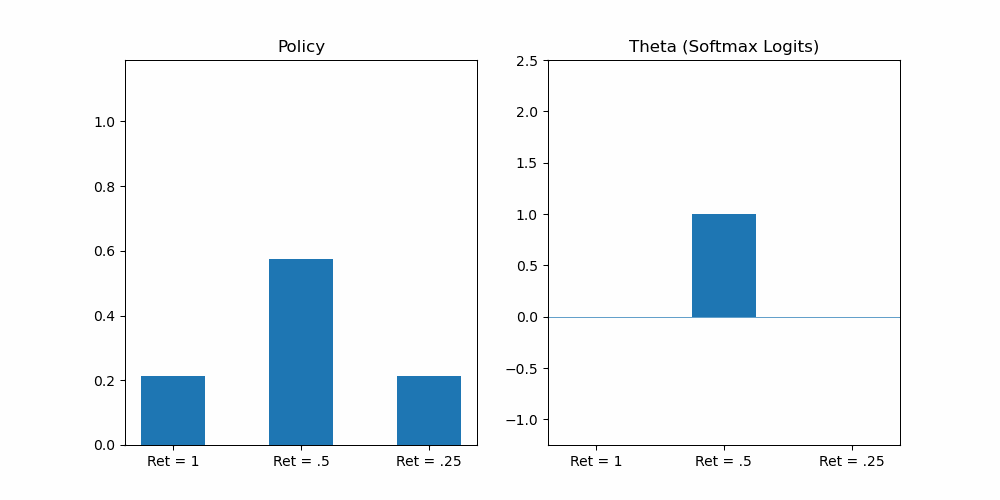

In [21]:
theta_0 = np.array([0.,1.,0.]) # Biased!
thetas, pis, incs, incs_idx = learn(theta_0, return_function, return_guided, act=act) # added the action selection
animate('return_guided_onpolicy.gif', thetas, pis, incs, incs_idx)

Action $1$ got selected the most! What happened here?

Well, remember that for every action we do, we move a bit in the direction of the gradient. **If an action is twice as probable to be sampled than others, it will be updated twice as much**. Since we nearly only have positive returns in this example, the updates will almost always increase the suboptimal action's probability. The gradient scales are not enough to compensate.

How can we solve this issue? Well, if an action is going to get twice the updates, we can simply **balance the gradient** by making each of its updates **twice as small**! You can think of it as varying the learning rate; however this is really a correction of the gradient term. 

More generally and formally, we can *divide the gradient by the action's probability*. This gives us the following corrected update:
$$
\begin{align}
\boldsymbol{\theta} &= \boldsymbol{\theta} + \alpha G_t \frac{\nabla \pi_\boldsymbol{\theta}\left(a \mid s\right)} {\pi_\boldsymbol{\theta}\left(a \mid s\right)}\\
                      &= \boldsymbol{\theta} + \alpha G_t \nabla \log \pi_\boldsymbol{\theta}\left(a \mid s\right)
\end{align}
$$

This is where the mysterious $\log$ term comes from in the PG formula! It is actually only here for **on-policy correction**. Let's see how this fix performs in the same settings:

In [22]:
lr = 0.25

def onpolicy_correction(theta, a, G_t):
    """ Uses G_t as information to drive its gradient. """
    grad_term = G_t * grad_pi(theta,a)/pi(theta)[a]# TODO on-policy correction
    return theta + lr*grad_term, grad_term[a], a

MovieWriter ffmpeg unavailable; using Pillow instead.


Animating 102 frames...
Done animating in 17.341975450515747s


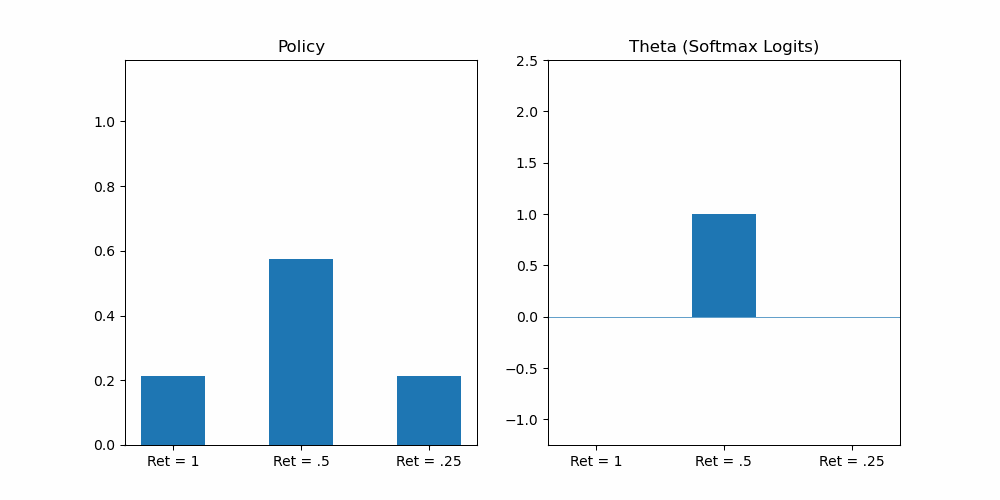

In [23]:
theta_0 = np.array([0.,1.,0.]) # Biased!
thetas, pis, incs, incs_idx = learn(theta_0, return_function, onpolicy_correction, act) # added the action selection
animate('onpolicy_correction.gif', thetas, pis, incs, incs_idx)

Perfect! We notice that the updates for less probable actions tend to be bigger.

This algorithm, in its full RL version -using a Monte-Carlo estimate of the return $G_t$- is called **REINFORCE**, and is the starting point of virtually all PG methods and courses.

#### Link with the Gradient Bandit
Note how in the code, we used the formula with $\frac{\nabla \pi_\boldsymbol{\theta}\left(a \mid s\right)} {\pi_\boldsymbol{\theta}\left(a \mid s\right)}$ rather than with the $\log$; this is just for conveninence. However remember, for a softmax policy, the gradient is $ \frac{ \partial \pi_\boldsymbol{\theta}\left(a_i \mid s \right)} {\partial \theta_j} = \pi_\boldsymbol{\theta}\left(a_j \mid s \right) \left( \delta_{ij} - \pi_\boldsymbol{\theta}\left(a_i \mid s \right)  \right) $
where $j$ indicates the index of the performed action, to avoid confusion with other actions. 

Therefore when computing the gradient term, the policy in $a_j$ vanishes! So if we say we're updating from action $a_j$ yielding return $G_t$:

$$ 
\begin{align}
  G_t \frac{\nabla \pi_\boldsymbol{\theta}\left(a_j \mid s\right)} {\pi_\boldsymbol{\theta}\left(a_j \mid s\right)}
&=  G_t \frac{\pi_\boldsymbol{\theta}\left(a_j \mid s \right) \left( \delta_{ij} - \pi_\boldsymbol{\theta}\left(a_i \mid s \right)  \right)} {\pi_\boldsymbol{\theta}\left(a_j \mid s\right)} \ \ \ \ \forall i\\
&= G_t \left( \delta_{ij} - \pi_\boldsymbol{\theta}\left(a_i \mid s \right)  \right)\ \ \ \ \forall i
\end{align}
$$

Does this update ring a bell? It should! With bandit reward $R_t$ instead of the return $G_t$, this is the **Gradient Bandit update**! Indeed, the Gradient Bandit is the Policy-Based version of Bandit algos, and very similar in nature to Policy Gradient methods. 

There is one difference with the update introduced in the lecture and lab though: the baseline. Let's get to it!

### 2.4. <span style="color:blue"> **TODO** </span> Adding the baseline
You might note that most of the updates in the plots so far have been green arrows; in other words, the algo believes that the action is good and tries to increase its probability. As we mentioned before, this is due to generally positive returns, meaning positive gradients. However, we know that only action $0$ is optimal, the others are inferior; their probabilities should decrease. How can we tell the algorithm to decrease suboptimal values?

We will steal an idea from the Gradient Bandit and use a **baseline**. Basically, this tells us "how well things usually go". Then, if we do better, we should augment the probablility of the action by doing a positive update! If we don't do as good, then we want a negative update. We can achieve this in one go with a substraction, $G_t-\bar{G_t}$.

Let's visualize our returns shifted by a baseline under a random policy: the mean return is $(1+0.5+0.25)/3\approx 0.58$:

0.5833333333333334


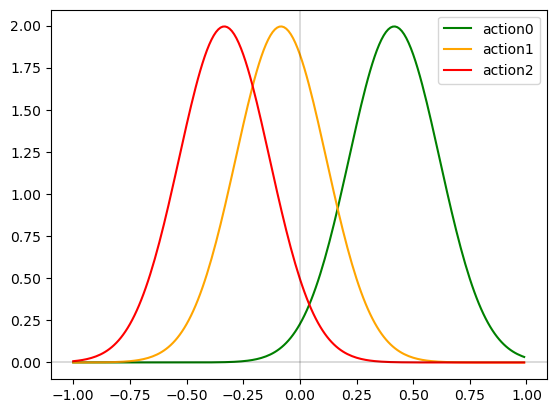

In [24]:
mean = (1+0.5+0.25)/3
print(mean)
x = np.arange(-1,1, 0.01)
plt.plot(x, gaussian(x, 1.-mean), color='green', label="action0")
plt.plot(x, gaussian(x, .5-mean), color='orange', label="action1")
plt.plot(x, gaussian(x, .25-mean), color='red', label="action2")
plt.axhline(0, color="black", linewidth=0.2)
plt.axvline(0, color="black", linewidth=0.2)
plt.legend()
plt.show()

Note how now action 0 is generally going to lead to positive returns, leading to an increase in probability, while actions 1 and 2 will generally lead to negative returns, decreasing their probability. This gap is going to widen even more as our policy improves and our expectations (baseline) increase!

In the context of Bandits, the baseline was simply the average reward obtained during the whole process. However, now that we are imagining a full RL setting, we can afford to use an estimate that is a little more precise: since we know we are at state $s$, an estimate of "how good things should be" is, by construction, the **Value Function** of our policy, $v_\pi\left(s\right)$. Obviously in practice, we use an estimate $\hat{V}_\pi$.

Our new update rule should therefore be:
$$
\begin{align}
\boldsymbol{\theta} = \boldsymbol{\theta} + \alpha \left(G_t - \hat{V}_\pi \left(s\right)\right) \nabla \log \pi_\boldsymbol{\theta}\left(a \mid s\right)
\end{align}
$$

Now, if the return we obtain $G_t$ is stronger than what our policy usually gets, $\hat{V}_\pi\left(s\right)$, it means the action $a$ we tried was good; otherwise, it was bad. Thanks to this substraction, we directly corrected the sign of the gradient!

In our code, it will make no difference with the Gradient Bandit baseline since we are in a Bandit setting, but in a broader setting we want to learn $\hat{V}$ with some form of TD learning, since we know it is most efficient. 

In [25]:
lr = 0.25
v_pi = 0

def baseline_update(theta, a, G_t):
    """ Substracts the value function as a baseline. """
    global v_pi
    # Value Function update
    v_pi += lr*(G_t - v_pi)# TODO weighted-average v_pi estimation 

    # Gradient
    grad_term = (G_t - v_pi)*grad_pi(theta,a)/pi(theta)[a]# TODO PG with baseline
    return theta + lr*grad_term, grad_term[a], a

MovieWriter ffmpeg unavailable; using Pillow instead.


Animating 91 frames...
Done animating in 15.594344854354858s


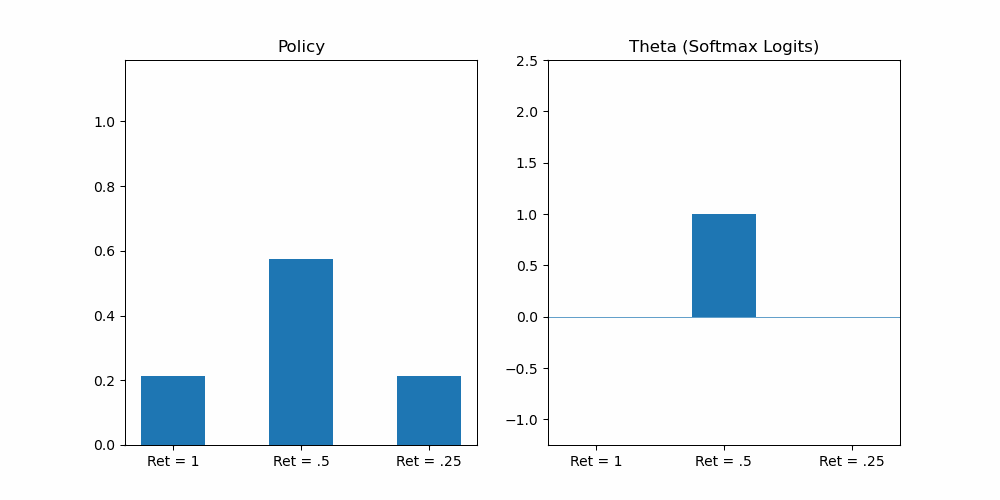

Baseline value: 0.8700627788703328


In [26]:
theta_0 = np.array([0.,1.,0.])
thetas, pis, incs, incs_idx = learn(theta_0, return_function, baseline_update, act)
animate('baseline_update.gif', thetas, pis, incs, incs_idx)
print("Baseline value: {}".format(v_pi))

Perfect! Notice how the updates are now much better balanced in positive and negative. We caught up to Gradient Bandit.

###  2.5. <span style="color:blue"> **TODO** </span> Advantage and Actor-Critic

#### Introducing $q_\pi \left(s, a\right)$
Although using a baseline really helps in reducing variance -it is virtually unthinkable not to use one in practice-, there is still a great amount of noise in our update rule, due to the very stochastic return term $G_t$. Imagine a scenario where we chose the best action, but some bad decision or bad luck down the line in the episode lead to a terrible return. Policy Gradient is going to severely punish our good action! This is sometimes referred to as the *credit assignment problem*: which actions should be blamed or commended for the return?

We know it's a good action because it should do better than others *in average*. We can actually find a way to replace the return $G_t$ with a quantity that represents our action with much more stability: the **Action-Value Function** $q_\pi \left(s, a \right)$. If we use $\hat{Q}_\pi \approx q_\pi$, the action should not be punished for consequences it is not responsible of. Mathematically, the action-value function is the expected return, so we can replace it in our gradient, since it is considering an expected trajectory. The new update rule is now therefore:
$$
\begin{align}
\boldsymbol{\theta} = \boldsymbol{\theta} + \alpha \left(\hat{Q}_\pi\left(s,a\right) - \hat{V}_\pi \left(s\right)\right) \nabla \log \pi_\boldsymbol{\theta}\left(a \mid s\right)
\end{align}
$$


We can now use all of our knowledge of action-value functions! Note that it is important we approximate $q_\pi$, not $q^*$, because we need it to be an estimate of $\mathbb{E}_\pi \left[ G_t \right]$. We're not trying to use our estimate $\hat{Q}\left(s,a\right)$ to solve the task!

(Since this is still a Bandit setting, the credit assignment isn't a massive problem, so the difference in performance is going to be minor.)

In [27]:
lr = 0.25
v_pi = 0
q_pi = np.array([0.,0.,0.])

def advantage_update(theta, a, G_t):
    """ Substracts the value function as a baseline. """
    global v_pi, q_pi
    # Value Function updates
    v_pi    += lr*(G_t - v_pi)# TODO v_pi estimation
    q_pi[a] += lr*(G_t - q_pi[a])# TODO q_pi estimation

    # Gradient
    grad_term = (q_pi[a] - v_pi) * grad_pi(theta,a)/pi(theta)[a]# TODO Advantage Actor-Critic PG
    return theta + lr*grad_term, grad_term[a], a

MovieWriter ffmpeg unavailable; using Pillow instead.


Animating 107 frames...
Done animating in 16.614412546157837s


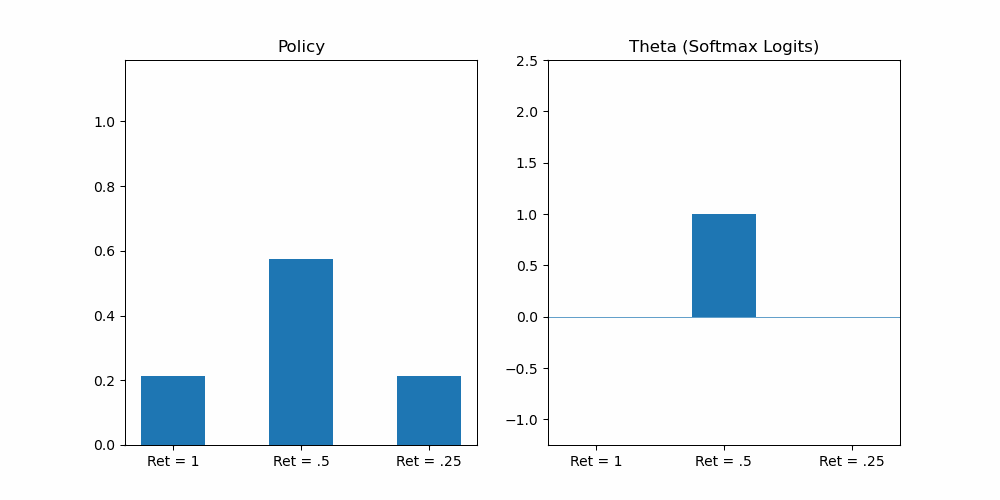

Baseline value: 0.9299851580156054
Q values: [1.07688699 0.540051   0.22262766]


In [28]:
theta_0 = np.array([0.,1.,0.])
thetas, pis, incs, incs_idx = learn(theta_0, return_function, advantage_update, act)
animate('advantage_update.gif', thetas, pis, incs, incs_idx)
print("Baseline value: {}".format(v_pi))
print("Q values: {}".format(q_pi))

We can see that the updates for each action are now nearly always in the correct direction! 

#### Interpretation: Actor-Critic
Let's take a moment to pause here, because this is an important change. We replaced the very noisy $G_t$ with a value-function, in other words, something that we can learn with TD Learning, using the idea of bootstrapping. We know that this idea is very powerful, because it uses the underlying MDP structure of the problem to solve it efficiently.

By replacing $G_t$ with an estimator, we introduced a **Critic**. In the RL book, a Critic is not simply used to describe any value-based function we use in a Policy-Based setting - otherwise, the baseline would be a Critic. Instead, the Critic has the important role of estimating the return $G_t$ that is the fundamental quantity to guide our gradient; and the Critic has the bootstrapping property, i.e. it can learn its value using the underlying structure of the MDP.

We therefore have now built an **Actor-Critic** Agent: the *Actor* $\pi_\boldsymbol{\theta}$ is the parametrized policy that learns to act, while the *Critic* $q_\pi$ learns the value of our policy, and guides its gradient towards stronger actions.

#### Interpretation: Advantage Function
In this lab, we could have introduced the Critic as $q_\pi$ or the baseline as $v_\pi$ in any order. But both of them have a crucial role, and the final update uses them in a very intuitive way - as a reminder: 

$$
\begin{align}
\boldsymbol{\theta} = \boldsymbol{\theta} + \alpha \left(\hat{Q}_\pi\left(s,a\right) - \hat{V}_\pi \left(s\right)\right) \nabla \log \pi_\boldsymbol{\theta}\left(a \mid s\right)
\end{align}
$$

What this update says is: "if the action $a$ we selected has a better average return than what we usually get, then we want to increase its probability; otherwise decrease it." This is actually more informative than that, since the gradient will also be scaled by the magnitude of the difference. We call this difference the **Advantage**:
$$a_\pi\left(s,a\right) \doteq q_\pi\left(s,a\right) - v_\pi \left(s\right) $$
The Advantage directly encodes how actions perform compared to one another - if an action has a positive Advantage, is it better than the average action in this state. It should therefore be clear why it appears in Policy-Gradient and why it can be so useful: this is exactly the information we need to know whether we increase or decrease an action's probability! By simply applying what we just defined, we therefore find the final update rule:

$$
\begin{align}
\boldsymbol{\theta} = \boldsymbol{\theta} + \alpha \hat{A}_\pi\left(s,a\right) \nabla \log \pi_\boldsymbol{\theta}\left(a \mid s\right)
\end{align}
$$
Which corresponds to **Advantage Actor-Critic**. 

#### Policy-Gradient variations
If all went well, you should now be quite confident with this slide from the course:
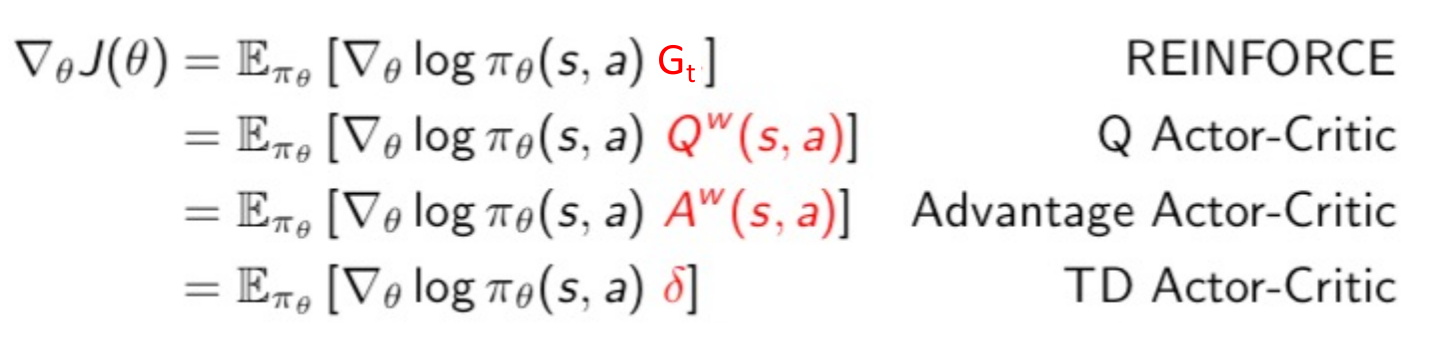

Indeed, we saw we can simply use $G_t$ to guide our gradient; but we can also use a critic, introducing $Q(s,a)$. We can add a baseline to the mix, leading to $Q(s,a) - V(s) = A(s,a)$. Can you figure out why the TD error $\delta$ would appear here?